In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, plot_violin, accuracy_perumtations, 
    age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps, plot_age_gap_hist_and_permutation_test,
    plot_age_gap_hist_with_thresh_and_permutation_test, deconfound,
    fit_deconfound_model, _add_ages_from_additional_sources,
)

/tmp/ipykernel_3088490/2300338955.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Tue Mar 28 14:02:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 27%   26C    P8     1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# TODO: 
# mail denis
# mail joschka
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?

In [4]:
#work_dir = '/home/jovyan/workspace-tueg/'
work_dir = '/home/jovyan/'
#work_dir = '/home/lukas/Code/brain_age/'

In [5]:
base_dir = os.path.join(work_dir, 'experiments')
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

#exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence, cv
#exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval

#exp = '2023-02-07T06:28:03.373666' # TCN exluding recs with age divergence, subject-wise cv
#exp = '2023-02-09T09:34:21.685021' # TCN exluding recs with age divergence, subject-wise fe 


#exp = '2023-02-10T23:14:51.938016'  # mixed patho and non-patho data
#exp = '2023-02-11T09:11:11.990975'  # subset non-patho, match patho and non-patho dists
#exp = '2023-02-11T09:11:23.883557'  # subset non-patho, uniform patho and non-patho dists

exp = '2023-02-15T18:59:11.767923'  # cv
exp = '2023-02-15T18:43:26.819382'  # fe

#exp = '2023-02-22T12:51:02.928667'

exp_dir = os.path.join(base_dir, exp)

In [6]:
configs = read_result(exp_dir, 'config')

In [7]:
configs

,augment,batch_size,data_path,date,debug,fast_mode,final_eval,intuitive_training_scores,loss,max_age,...,standardize_data,standardize_targets,subsample,subset,target_name,tmin,tmax,valid_set_i,window_size_samples,run_name
0,dropout,128,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-15T18:43:26.819382,1,1,1,1,mae,-1,...,1,1,0,normal,age,60,-1,0,6000,decode_age
0,dropout,128,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-15T18:43:26.819382,1,1,1,1,mae,-1,...,1,1,0,normal,age,60,-1,0,6000,decode_age
0,dropout,128,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-15T18:43:26.819382,1,1,1,1,mae,-1,...,1,1,0,normal,age,60,-1,0,6000,decode_age
0,dropout,128,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-15T18:43:26.819382,1,1,1,1,mae,-1,...,1,1,0,normal,age,60,-1,0,6000,decode_age
0,dropout,128,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-15T18:43:26.819382,1,1,1,1,mae,-1,...,1,1,0,normal,age,60,-1,0,6000,decode_age


In [8]:
configs.iloc[0]

augment                                                                dropout
batch_size                                                                 128
data_path                    /home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...
date                                                2023-02-15T18:43:26.819382
debug                                                                        1
fast_mode                                                                    1
final_eval                                                                   1
intuitive_training_scores                                                    1
loss                                                                       mae
max_age                                                                     -1
min_age                                                                     -1
model_name                                                                 tcn
n_epochs                                            

In [9]:
assert configs['final_eval'].nunique() == 1

In [10]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed']]

,model_name,target_name,valid_set_i,seed
0,tcn,age,0,20230214
0,tcn,age,0,20230215
0,tcn,age,0,20230216
0,tcn,age,0,20230217
0,tcn,age,0,20230218


In [11]:
scores = read_result(exp_dir, 'score')

In [12]:
score = 'mae'  # mae, mpe, r2
if (configs['final_eval'] == '1').all():
    display(scores.loc[[score]].mean())
else:
    display(scores.loc[[score]].groupby('seed').mean())

train                              2.676739e+00
eval                               6.517127e+00
eval_not_normal                    1.341554e+01
transition                         1.177079e+01
non_pathological                   1.337067e+01
pathological                       1.625009e+01
transition_long                    1.169707e+01
non_pathological_long              1.202639e+01
pathological_long                  1.579273e+01
transition_long_clean_age          1.212099e+01
non_pathological_long_clean_age    1.181561e+01
pathological_long_clean_age        1.563892e+01
seed                               2.023022e+07
valid_set_i                        0.000000e+00
dtype: float64

In [13]:
histories = read_result(exp_dir, 'history')

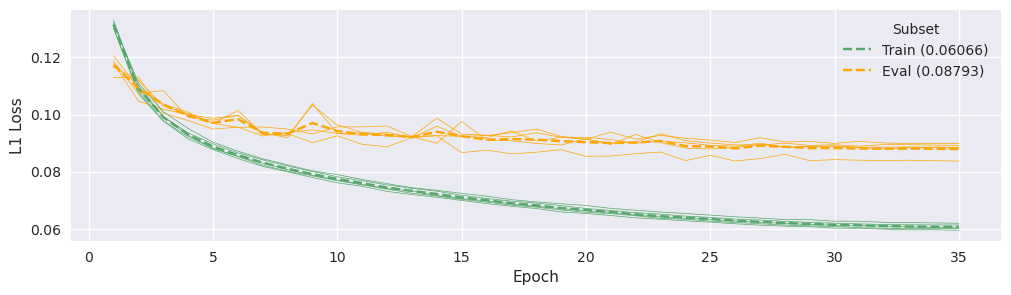

In [14]:
if (configs['final_eval'] == '1').all():
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], 'L1 Loss', 'Eval')
    ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_curves.png'), dpi=300, bbox_inches='tight')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], 'L1 Loss')
        # ax.set_title(f'Deep4, lr=0.005')
        # ax.set_title(f'Seed: {n1}')
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_curves_{n1}.png'), dpi=300, bbox_inches='tight')

In [15]:
preds = read_result(exp_dir, 'preds')

In [16]:
accs = []
for n1, g1 in preds.groupby('seed'):
    acc = balanced_accuracy_score(g1.y_true.to_numpy().astype(int), g1.y_pred.to_numpy().astype(int))
    accs.append(acc)
mean_acc = np.mean(accs)
print(f'avg acc over {preds.seed.nunique()} seeds with {preds.valid_set_i.nunique()} folds', mean_acc)

avg acc over 5 seeds with 1 folds 0.03667891856571101


In [17]:
subject_wise = True

In [18]:
def heatmaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)]
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean(numeric_only=True)
        if subject_wise:
            g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
        if detrend is not None:
            model = fit_deconfound_model(
                g1[g1.pathological == False].y_true, 
                g1[g1.pathological == False].y_pred, 
                detrend,
            )
            g1['y_pred'] = g1.y_pred - model(g1.y_true)
        """
        g1 = deconfound(g1, detrend)
        """
        ax = plot_heatmaps(g1, bin_width)#, 100, hist_max_count=12)
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = g1[g1.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            if subject_wise:
                g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
            if detrend is not None:
                model = fit_deconfound_model(
                    g1[g1.pathological == False].y_true, 
                    g1[g1.pathological == False].y_pred, 
                    detrend,
                )
                g1['y_pred'] = g1.y_pred - model(g1.y_true)
            """
            g1 = deconfound(g1, detrend)
            """
            ax = plot_heatmaps(g1, bin_width)#, 100, hist_max_count=100)
    return ax

In [19]:
def gaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean(numeric_only=True)
        if subject_wise:
            g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
        if detrend is not None:
            model = fit_deconfound_model(
                g1[g1.pathological == False].y_true, 
                g1[g1.pathological == False].y_pred, 
                detrend,
            )
            g1['y_pred'] = g1.y_pred - model(g1.y_true)
        """
        g1 = deconfound(g1, detrend)
        """
        ax = plot_age_gap_hist_and_permutation_test(
            g1, bin_width, n_repetitions,
        )
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = preds[preds.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            if subject_wise:
                g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
            if detrend is not None:
                model = fit_deconfound_model(
                    g1[g1.pathological == False].y_true, 
                    g1[g1.pathological == False].y_pred, 
                    detrend,
                )
                g1['y_pred'] = g1.y_pred - model(g1.y_true)
            """
            g1 = deconfound(g1, detrend)
            """
            ax = plot_age_gap_hist_and_permutation_test(
                g1, bin_width, n_repetitions,
            )
    return ax

In [20]:
def proxy(preds, configs, sex, min_age, max_age, cols, detrend, bin_width, thresh1=None, thresh2=None):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean(numeric_only=True)
        if subject_wise:
            g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
        if detrend is not None:
            model = fit_deconfound_model(
                g1[g1.pathological == False].y_true, 
                g1[g1.pathological == False].y_pred, 
                detrend,
            )
            g1['y_pred'] = g1.y_pred - model(g1.y_true)
        """
        g1 = deconfound(g1, detrend)
        """
        ax = plot_age_gap_hist_with_thresh_and_permutation_test(
            g1, bin_width, n_repetitions, thresh1, thresh2,
        )
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = preds[preds.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            if subject_wise:
                g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
            if detrend is not None:
                model = fit_deconfound_model(
                    g1[g1.pathological == False].y_true, 
                    g1[g1.pathological == False].y_pred, 
                    detrend,
                )
                g1['y_pred'] = g1.y_pred - model(g1.y_true)
            """
            g1 = deconfound(g1, detrend)
            """
            ax = plot_age_gap_hist_with_thresh_and_permutation_test(
                g1, bin_width, n_repetitions,
            )
    return ax

In [21]:
bin_width = 2
n_repetitions = 100  # ! actually 100000 !
cols = ['y_pred', 'y_true', 'pathological', 'subject', 'index', 'subset']

In [22]:
if n_repetitions != 100000:
    print("WARNING! Wrong number of reps!")

WARNING! Wrong number of reps!


In [23]:
save = False
age_limits = [(None, 30), (30, 60), (60, None)]  #[(None, 30), (30, 60), (60, None)]#
sexes = [None]#['F', 'M'] #[None]#
detrends = ['quadratic']  # None, linear, quadratic
# extracted from cv
thresh1 = -8.786315726356626 if (configs['final_eval'] == '1').all() else None 
thresh2 = 4.877341101987973 if (configs['final_eval'] == '1').all() else None
#thresh1 = None
#thresh2 = None

Thu Mar 23 14:56:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 56%   57C    P2    76W / 250W |   2085MiB / 11264MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

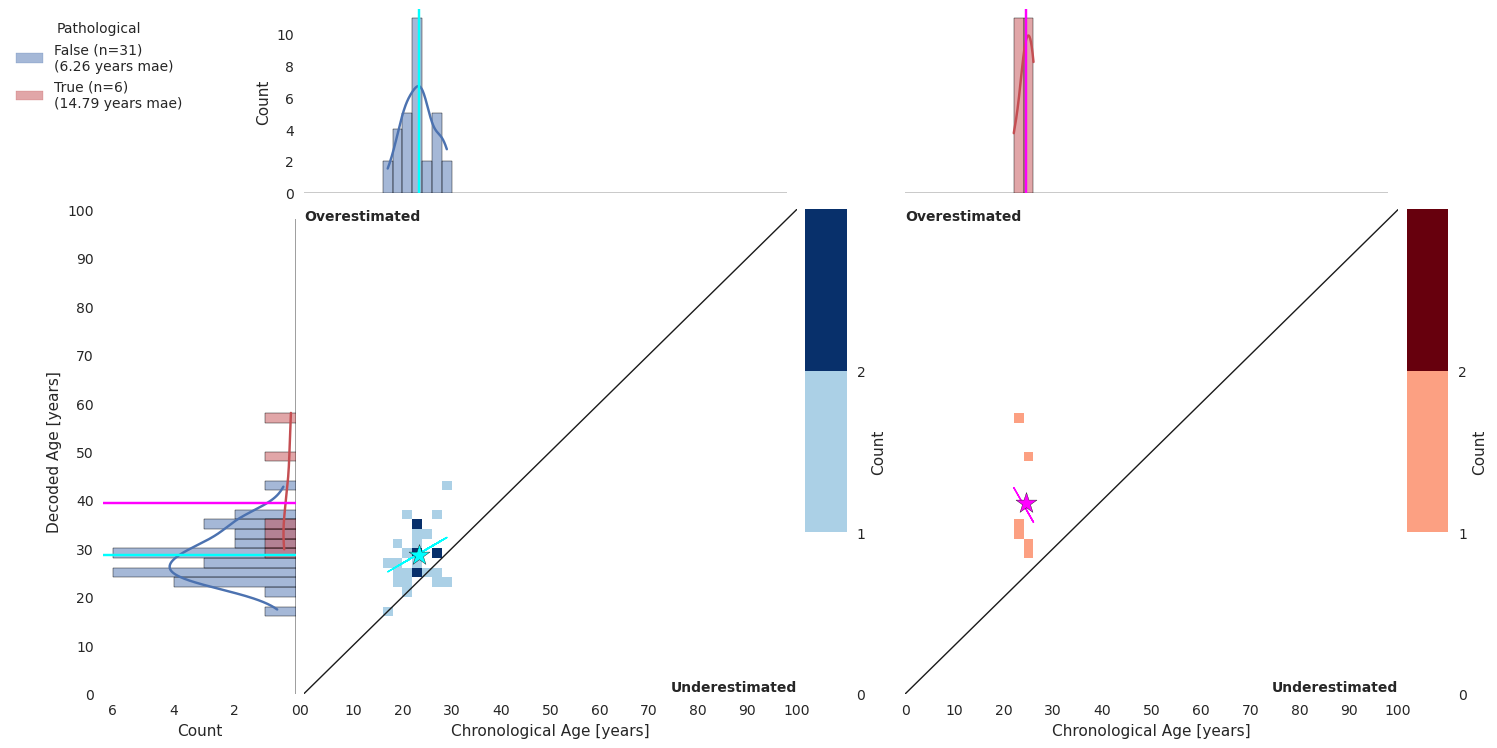

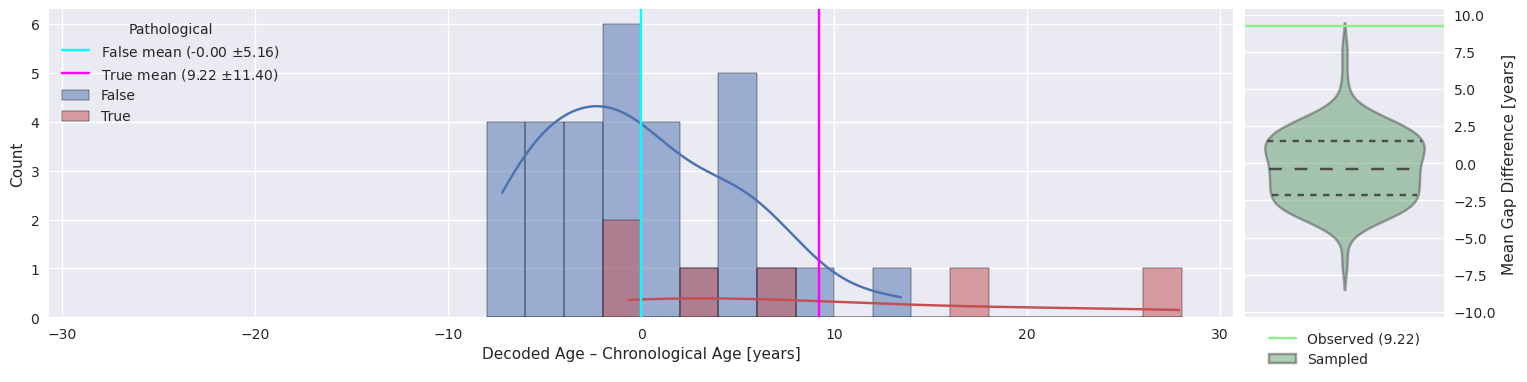

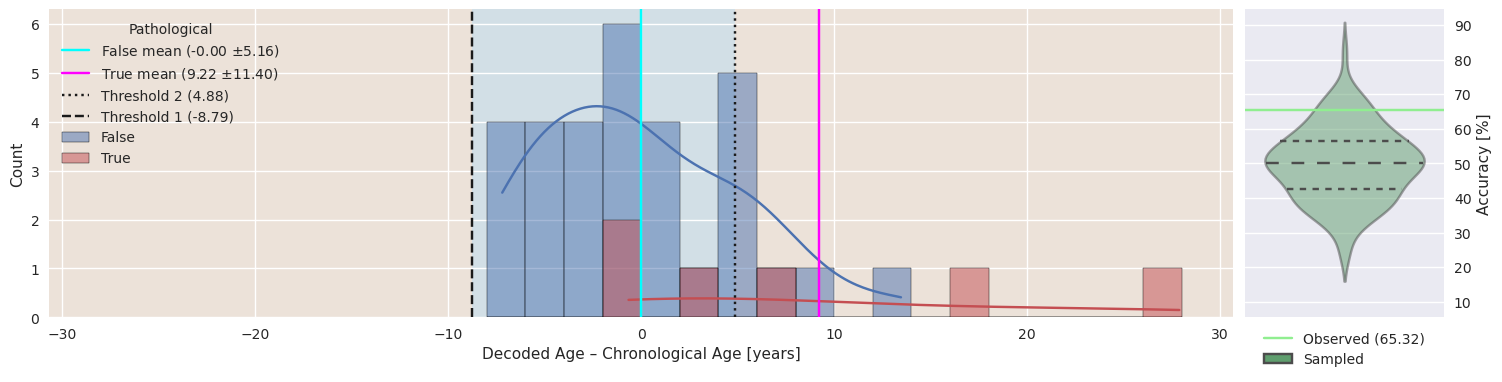

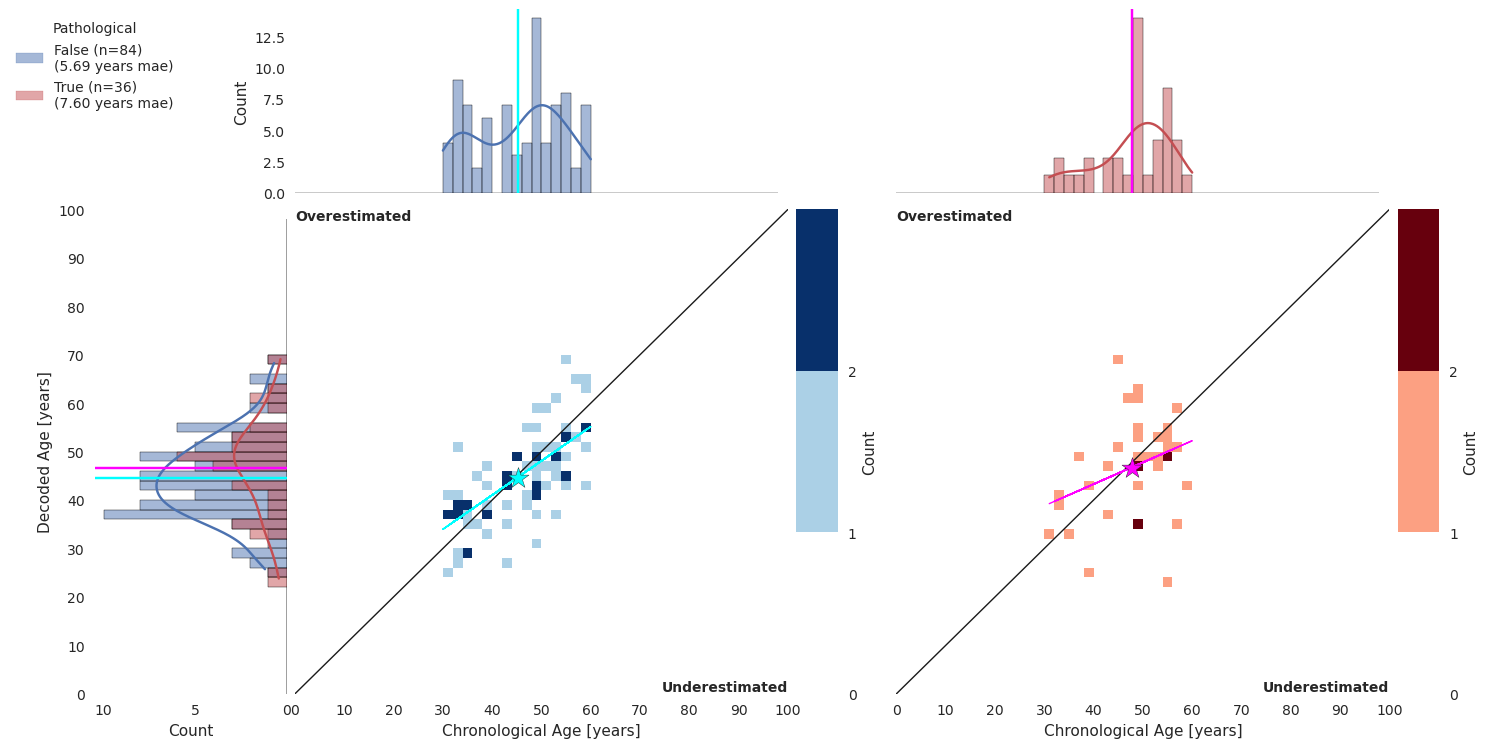

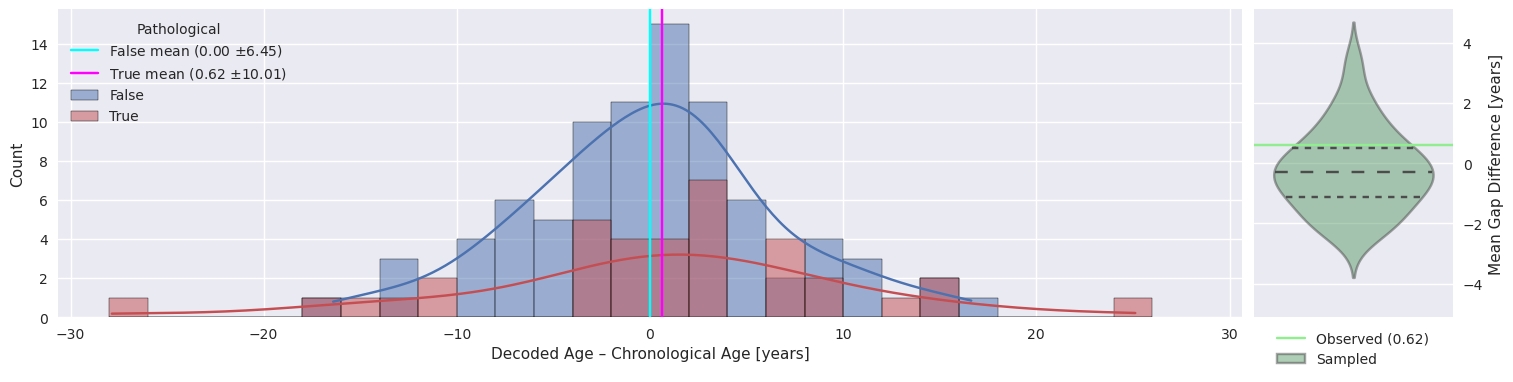

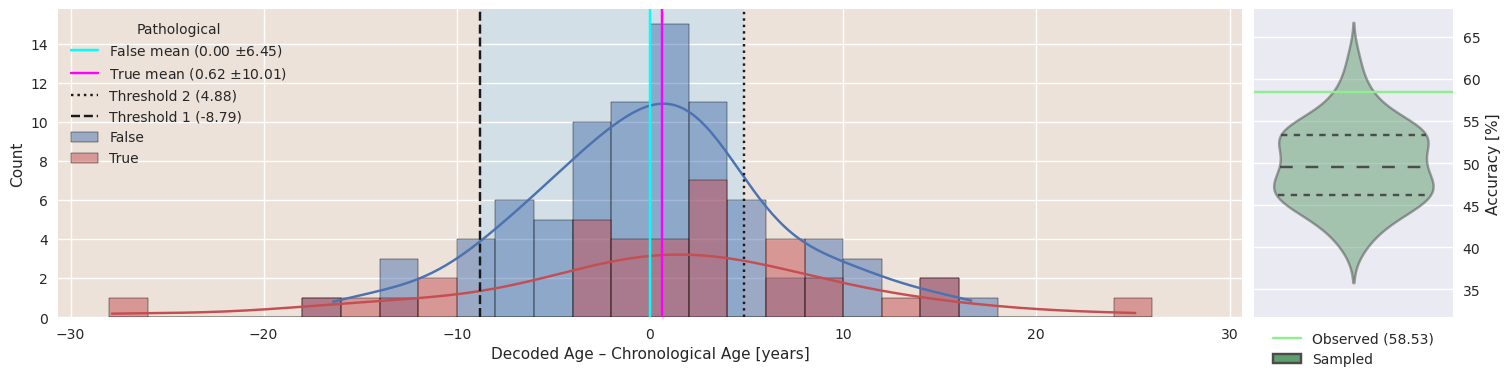

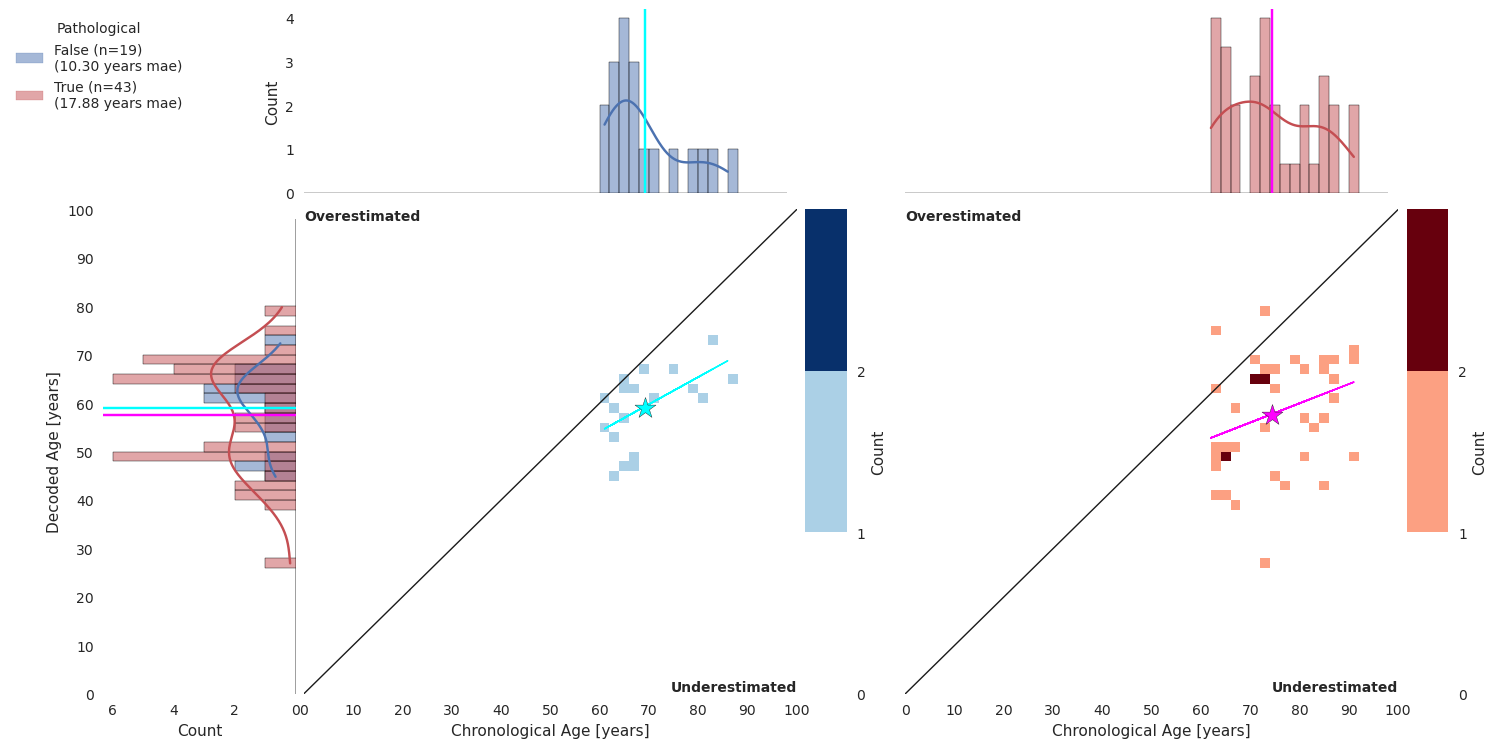

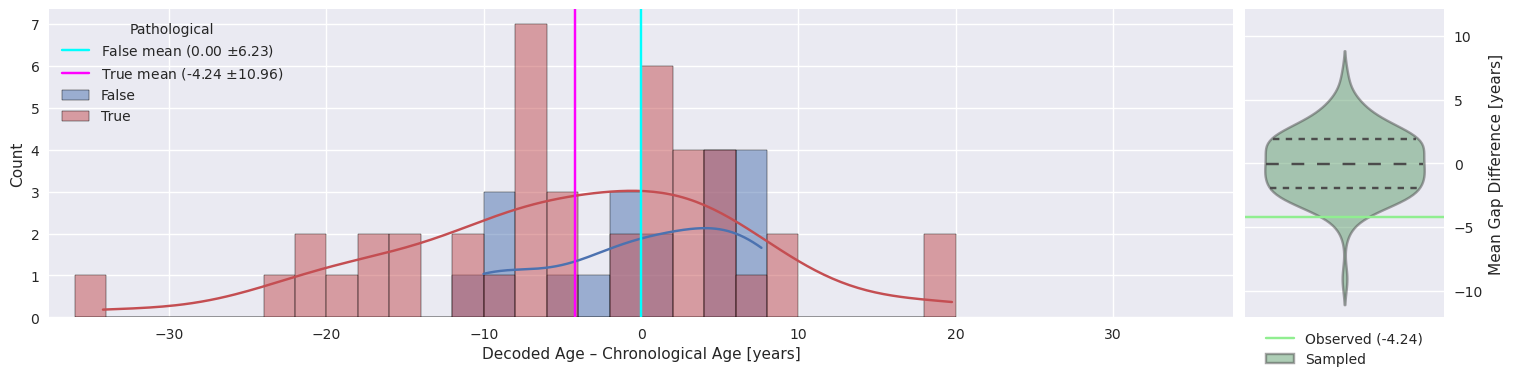

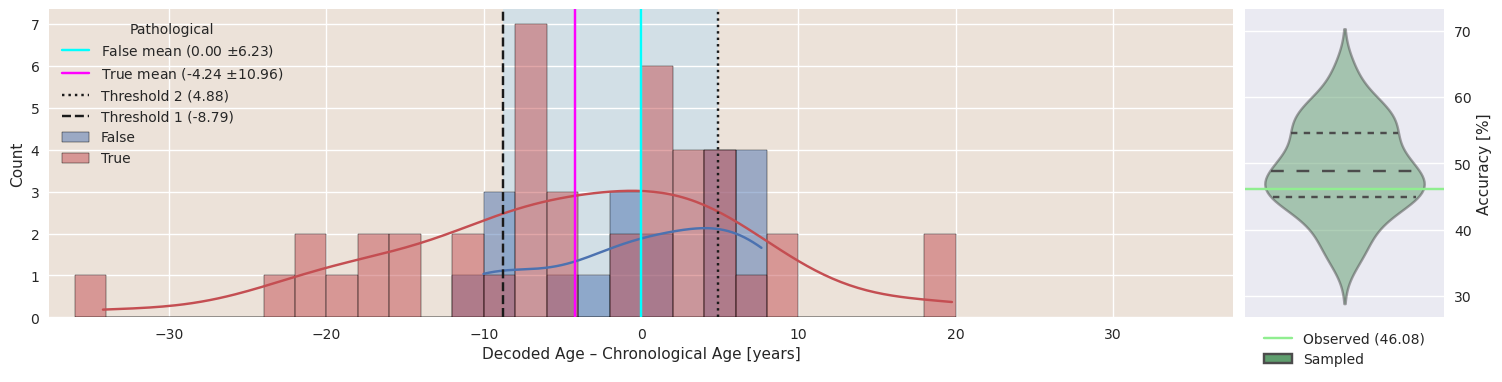

In [30]:
for (min_age, max_age) in age_limits:
    for sex in sexes:
        for detrend in detrends:
            max_age = preds.age.max() if max_age is None else max_age
            min_age = preds.age.min() if min_age is None else min_age
            print(min_age, max_age, sex, detrend, thresh1, thresh2)
            # actual predictions can never be detrended as this would be cheating
            ax = heatmaps(preds, configs, sex, min_age, max_age, cols, None, bin_width)
            if save:
                ax.get_figure().savefig('/home/jovyan/eval_heatmaps.jpg', bbox_inches='tight', dpi=300)
            #ax = gaps(preds, configs, sex, min_age, max_age, cols, None, bin_width)
            ax = gaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width)
            if save:
                ax.get_figure().savefig('/home/jovyan/eval_gaps.jpg', bbox_inches='tight', dpi=300)
            ax = proxy(preds, configs, sex, min_age, max_age, cols, detrend, bin_width, thresh1, thresh2)
            if save:
                ax.get_figure().savefig('/home/jovyan/eval_proxy.jpg', bbox_inches='tight', dpi=300)

In [65]:
model = fit_deconfound_model(preds.y_true, preds.y_pred, 'linear')

In [66]:
preds.y_pred - model(preds.y_true)

0      36.493414
1      43.840008
2      39.115610
3      38.386027
4      32.234675
         ...    
101    26.140277
102    37.948827
103    23.657416
104    44.857129
105    46.336879
Length: 1215, dtype: float64

In [87]:
model = fit_deconfound_model(g1[g1.pathological == False].y_true, 
                             g1[g1.pathological == False].y_pred, 'linear')

In [88]:
g1.y_pred - model(g1.y_true)

0      35.011880
1      43.535131
2      42.005782
3      35.206030
4      30.948266
         ...    
101    33.201082
102    36.243225
103    30.718220
104    46.398344
105    43.170209
Length: 243, dtype: float64

In [6]:
# TODO: read predictions of original longitudinal datasets and make selection
# long recs (still >= 2 recs per subject)
# clean age (still >= 2 recs per subject)

In [7]:
import re

import mne

In [8]:
from decode_tueg import _reject_derivating_ages

In [9]:
ds_name = 'transition'
min_mins = 15
clean_age = True

In [10]:
preds = read_result(exp_dir, f'longitudinal_{ds_name}')

In [11]:
preds['path'] = [p.replace('/data/datasets/TUH/EEG/', '/home/jovyan/mne_data/TUH/') for p in preds.path]

In [12]:
preds.shape, preds.subject.nunique()

((16785, 23), 525)

In [13]:
if clean_age:
    assert min_mins is not None
    gs = []
    for p, g in preds.groupby('path'):
        raw = mne.io.read_raw_edf(p, verbose='error')
        rec_year = raw.info['meas_date'].year
        # seems like one (?) header broke in preprocessing. read header of original unpreprocessed reocrding
        header = TUHAbnormal._read_edf_header(p)
        pattern = r'\d\d-\w\w\w-(\d\d\d\d)'
        matches = re.findall(pattern, str(header))
        if len(matches) != 1:
            birthyear = np.nan
        else:
            birthyear = int(matches[0])
        g['date_age'] = int(rec_year) - birthyear

        pattern = r'(\d+)[ -]+?[years]{3,5}[ -]+?[old]{3}'
        # is this also fine? also finds 33 y.o. often used in old reports
        #pattern = r'(\d+)[ -]+?[years]{1,5}[ -.]+?[old]{1,3}[ .]+?'  
        matches = re.findall(pattern, g.iloc[0].report)
        if len(matches) >= 1:
            # assume report always starts with 'XX year old ...'
            match = int(matches[0])
        elif len(matches) == 0:
            match = np.nan
        g['report_age'] = match
        gs.append(g)
    gs = pd.concat(gs).reset_index()
    gs.shape, gs.subject.nunique()
    
    preds = gs

    ids = _reject_derivating_ages(preds)
    preds = preds.iloc[ids]
    preds = preds.set_index('index')
    preds.shape, preds.subject.nunique()

In [14]:
gs = []
for seed, group in preds.groupby('seed'):
    group['duration'] = group.n_samples / group.sfreq
    if min_mins is not None:
        group = group[group.duration >= min_mins*60]
    # for eacht subject, there have to be at least two recs still after min duration selection
    for subject, g in group.groupby('subject'):
        if len(g) >= 2:
            # if this is transition, we require both pathologies
            if 'transition' in ds_name and g.pathological.nunique() != 2:
                continue
            gs.append(g)
gs = pd.concat(gs)
preds = gs

In [15]:
preds.shape, preds.subject.nunique()

((2800, 26), 221)

In [16]:
for seed, group in preds.groupby('seed'):
    break

In [17]:
group.shape, group.subject.nunique()

((560, 26), 221)

In [18]:
group.groupby('subject').head(1).gender.value_counts()

F    119
M    102
Name: gender, dtype: int64

In [19]:
subject_wise = False

In [20]:
if subject_wise:
    preds = preds.groupby(['subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)

<AxesSubplot: xlabel=' ', ylabel='Count'>

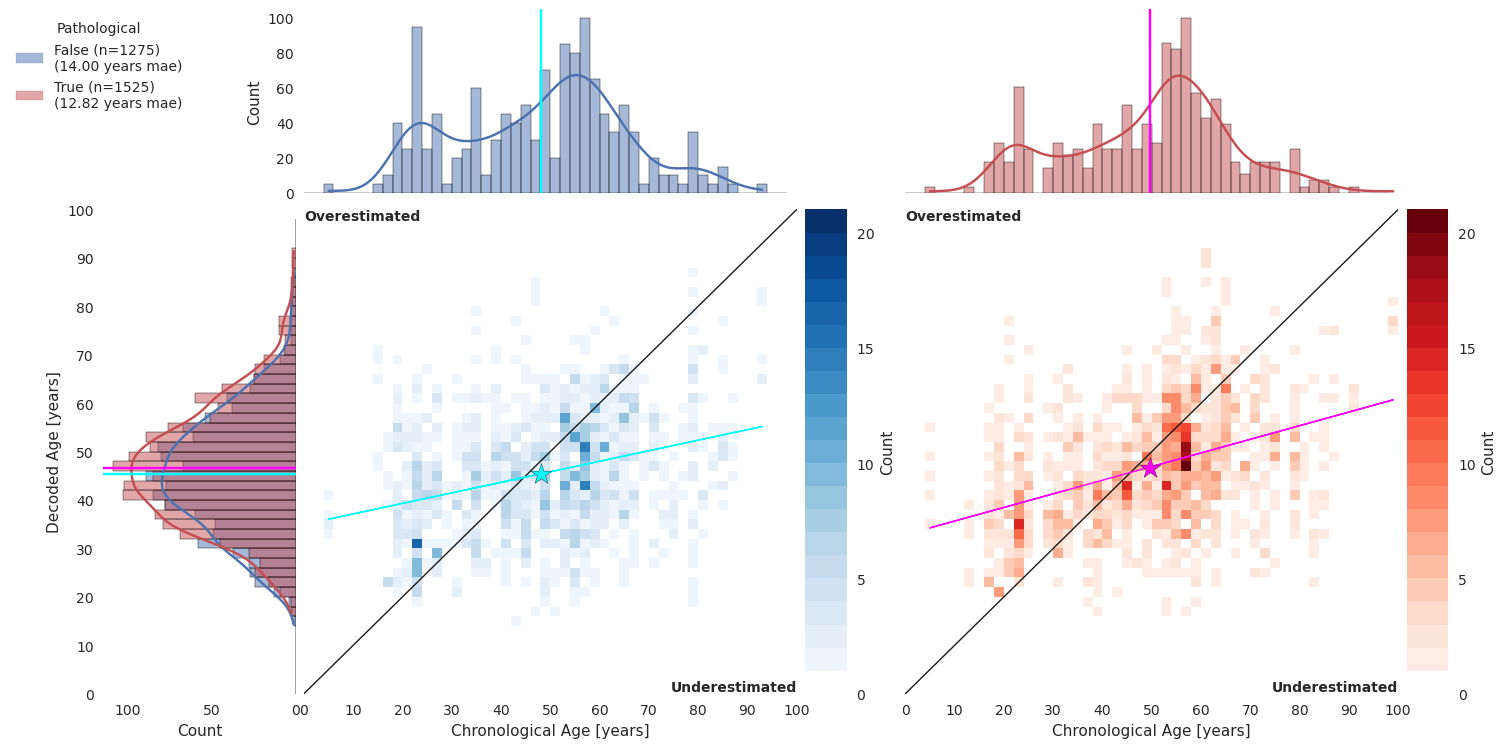

In [21]:
plot_heatmaps(preds, bin_size=2)

In [22]:
gs_01, gs_10 = [], []
for n, g in preds.groupby('subject'):
    #if len(g) == 2:
    if g.pathological.diff().sum() > 0:
        gs_10.append(g)
    elif g.pathological.diff().sum() < 0:
            gs_01.append(g)
    else:
        assert g.pathological.diff().sum() == 0
        #print(n)
if gs_01:
    gs_01 = pd.concat(gs_01)
if gs_10:
    gs_10 = pd.concat(gs_10)

In [23]:
for seed, g in gs_01.groupby('seed'):
    break
g.shape, g.subject.nunique()

((294, 26), 120)

In [24]:
for seed, g in gs_10.groupby('seed'):
    break
g.shape, g.subject.nunique()

((182, 26), 78)

In [25]:
gs_01 = gs_01.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)
gs_10 = gs_10.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)

<AxesSubplot: xlabel=' ', ylabel='Count'>

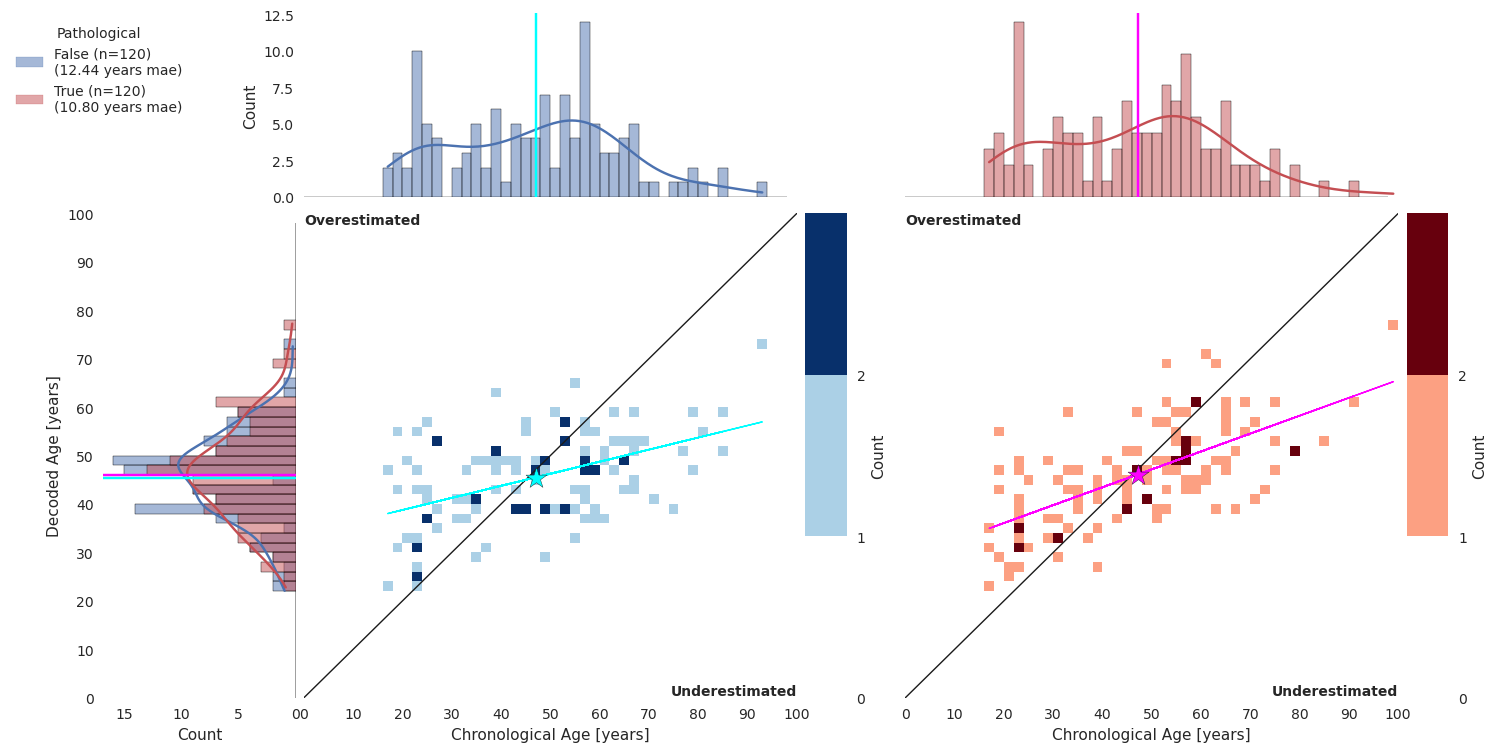

In [26]:
plot_heatmaps(gs_01, bin_size=2)

<AxesSubplot: xlabel=' ', ylabel='Count'>

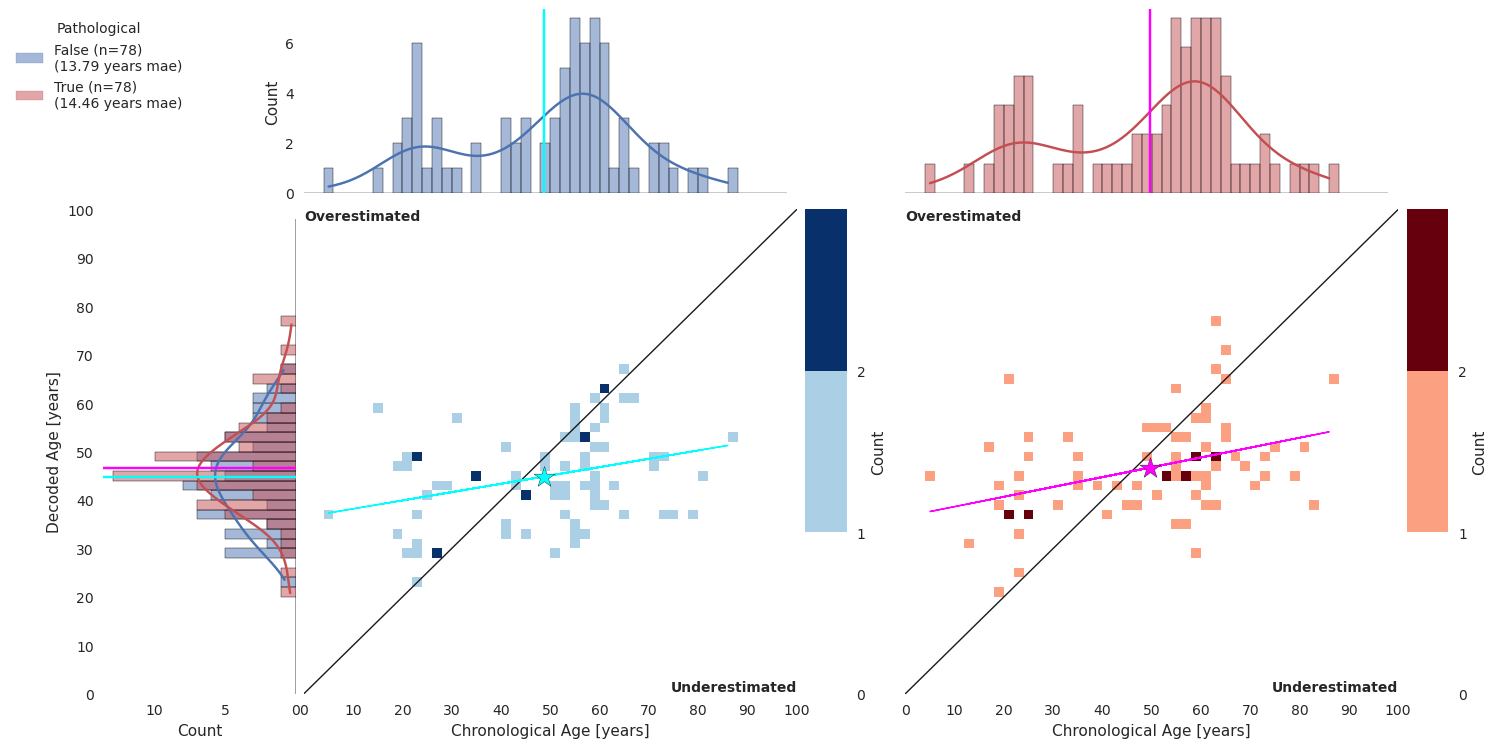

In [27]:
plot_heatmaps(gs_10, bin_size=2)

In [29]:
preds.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)

,subject,pathological,y_true,y_pred,year,month,day,session,segment,sfreq,n_samples,age,train,seed,valid_set_i,date_age,report_age
0,5,0,50.999999,47.368072,2004.0,5.0,20.0,3.00,1.00,250.0,3.132500e+05,51.0,1.0,20230216.0,0.0,51.0,51.0
1,5,1,50.600000,45.808719,2003.6,6.6,13.2,2.60,0.60,250.0,2.824000e+05,50.6,1.0,20230216.0,0.0,50.6,50.6
2,15,0,46.500000,38.641553,2002.5,11.5,2.5,1.25,0.75,250.0,1.657500e+05,46.5,1.0,20230216.0,0.0,46.5,46.5
3,16,0,20.000000,38.732082,2006.0,3.0,10.0,3.00,5.00,250.0,9.208333e+04,20.0,1.0,20230216.0,0.0,20.0,19.0
4,16,1,23.000000,35.742481,2009.0,4.5,10.5,3.00,0.50,250.0,1.875000e+05,23.0,1.0,20230216.0,0.0,23.0,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,13363,0,34.000000,36.716154,2015.0,9.0,9.0,1.00,0.00,250.0,4.332500e+05,34.0,1.0,20230216.0,0.0,34.0,34.0
736,13410,1,30.000001,43.952664,2015.0,11.0,3.0,3.00,1.50,256.0,2.902656e+06,30.0,1.0,20230216.0,0.0,30.0,30.0
737,13416,0,49.000000,54.803021,2015.0,6.0,19.0,1.00,0.00,1000.0,1.262000e+06,49.0,1.0,20230216.0,0.0,49.0,49.0
738,14382,0,33.000001,37.938403,2016.0,2.0,5.0,2.00,0.00,256.0,9.495040e+05,33.0,1.0,20230216.0,0.0,33.0,32.0


In [25]:
for l, ll in preds.groupby(['subject', 'pathological'], as_index=False):
    break

In [28]:
ll.mean(numeric_only=True)

y_true          5.100000e+01
y_pred          4.736807e+01
year            2.004000e+03
month           5.000000e+00
day             2.000000e+01
subject         5.000000e+00
session         3.000000e+00
segment         1.000000e+00
sfreq           2.500000e+02
n_samples       3.132500e+05
age             5.100000e+01
pathological    0.000000e+00
train           1.000000e+00
seed            2.023022e+07
valid_set_i     0.000000e+00
date_age        5.100000e+01
report_age      5.100000e+01
dtype: float64